# Expression Cloning

In [1]:
import igl
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter
from scipy.sparse import  diags
from scipy.sparse.linalg import spsolve

import torch
import torch.nn as nn
import torch.optim
from tqdm import tqdm

import pickle

from utils.ict_face_model import ICT_face_model
from utils.util import *

## create mesh set

In [2]:

ict = ICT_face_model()

with open('./data/corr_vertex_bc_src2tgt.pkl', 'rb') as f:
    corr_src2tgt_bc = pickle.load(f)
    
with open('./data/corr_vertex_bc_tgt2src.pkl', 'rb') as f:
    corr_tgt2src_bc = pickle.load(f)
    
V, F = igl.read_triangle_mesh("./data/source_restpose_mesh.obj")
V_, F_ = igl.read_triangle_mesh("./data/source_fitted_mesh.obj")
# V_, F_ = igl.read_triangle_mesh("data/ict_orig_100_trimesh.obj")

# newV, newF = igl.read_triangle_mesh("data/m02_deformed-0.2.obj")
newV, newF = igl.read_triangle_mesh("./data/target_restpose_mesh.obj")
## Note that both mesh has same mesh structure! -> F == newF
newV = rescale(newV ,V)
R = np.eye(3)
M_SCALE=3
M_DESCALE=1/M_SCALE
trns = np.array([0,0,0])
newV = newV*M_SCALE
# newV, R = random_rotate_points(newV * M_SCALE,return_rot=True)
newV = newV+trns
V_ = np.matmul(V_, R) * M_SCALE + trns

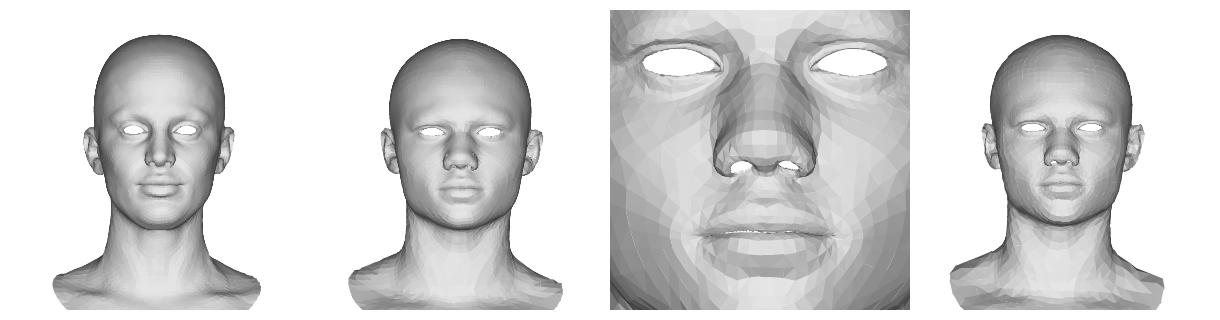

In [3]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = 0.6
# mesh that you wanna render
FRAME=150
v_list=[ V, np.matmul(V_,R.T)*M_DESCALE, newV, np.matmul(newV,R.T)*M_DESCALE ]
v_list=[ v*mesh_scale for v in v_list]
# f_list=[ F ]*len(v_list)
f_list=[ F, F_, newF, newF ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,0,0] ]*len(v_list)

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')

## Animation for the source mesh

In [4]:
# motions = np.load(r'_tmp\040.npy')
# print(motions.shape)

blendshapes = ict.exp_basis[:,:11248]
BS = 26
BS1 = 26
BS2=5

# motions = np.load(r'_tmp\040.npy')
# displacements = motions - V[None]
# tmpv, tmpf = igl.read_triangle_mesh("data/source_deformed_mesh.obj")
# displacements = blendshapes[BS1]+blendshapes[BS2]
displacements = blendshapes[[26,5,11]].sum(0)
# displacements = tmpv - V
print(displacements.shape, displacements.max())

(11248, 3) 0.083766006


## Get local coordinate system via TBN matrix

In [5]:
# V_tgt = (V[F[corr_src2tgt_bc[0]]]*(corr_src2tgt_bc[1][...,None])).sum(1)
V_TBN = get_TBN_foreach_vertex(V, F)
# V_TBN = get_TBN_foreach_vertex(V_tgt, newF)

# corr_newV = (newV[newF[corr_tgt2src_bc[0]]]*(corr_tgt2src_bc[1][...,None])).sum(1)
# newV_TBN = get_TBN_foreach_vertex(corr_newV, F)
# newV = (V[F[corr_src2tgt_bc[0]]]*(corr_src2tgt_bc[1][...,None])).sum(1)
# newV_TBN = get_TBN_foreach_vertex(newV, newF)
newV_TBN = get_TBN_foreach_vertex(V_, F_)


print(V_TBN.shape, V_TBN.min(), V_TBN.max())
print(newV_TBN.shape, newV_TBN.min(), newV_TBN.max())

(11248, 3, 3) -0.9999952973241975 0.9999996924041864
(11248, 3, 3) -0.9999926451422037 0.9999899533925427


## Scale using BB

In [6]:
# Vs = get_scale_foreach_vertex(V, F)
# newVs = get_scale_foreach_vertex(newV, F)
# newS = newVs/Vs
# newS_src = get_scale_foreach_triangle(V, F)
# newS_def = get_scale_foreach_triangle(np.matmul(newV, R.T), F)

newS_src = get_cell_bbox_scales(V, F)
newS_def = get_cell_bbox_scales(V_, F_)
newS = newS_def / newS_src

# newS_src = get_scale_foreach_triangle(V, F)
# newS_def = get_scale_foreach_triangle(np.matmul(newV, R.T), newF)
# corr_newS_def = (newS_def[newF[corr_tgt2src_bc[0]]]*(corr_tgt2src_bc[1][...,None])).sum(1)
# newS = corr_newS_def / newS_src

    
# newS = gaussian_filter(newS, 5, mode='nearest')

# Lap = igl.cotmatrix(V, F)
# newS = smooth(newS, Lap, loop=2, t=0.03)

# newS = mesh_smooth(V, F, newS, tau=0.1)
# newS[:,0] = gaussian_filter1d(newS[:,0], 3,mode='nearest')
# newS[:,1] = gaussian_filter1d(newS[:,1], 3,mode='nearest')
# newS[:,2] = gaussian_filter1d(newS[:,2], 3,mode='nearest')

# max_std = newS.std(0)*3
# for i in range(3):
#     tmp = newS[:, i]
#     tmp[tmp > max_std[i]] = max_std[i]
#     newS[:, i] = tmp

# newS = newS @ np.eye(3)
newS = np.eye(3)[None,:,:] * newS[:,:,None]
print(newS.shape, newS.min(), newS.max())

(11248, 3, 3) 0.0 391.10492542525196


## Animation with Motion Vectors

In [23]:
# MAT = newS * np.einsum('bcn, bnk->bck', newV_TBN.transpose(0,2,1), V_TBN)
MAT = np.einsum('bcn, bnk->bck', newV_TBN.transpose(0,2,1), V_TBN)
MAT = np.einsum('bcn, bnk->bck', newS, MAT)


new_displacements = np.einsum('bck, bk->bc', MAT, displacements)
## filtering...
new_displacements = mesh_smooth(V, F, new_displacements, tau=0.01)

# SAMPLE
new_displacements = (new_displacements[F[corr_src2tgt_bc[0]]]*(corr_src2tgt_bc[1][...,None])).sum(1)
# new_displacements = (new_displacements[F[corr_src2tgt_bc[0]]]).mean(1)

# filtering...
new_displacements = mesh_smooth(newV, newF, new_displacements, tau=0.01)



# lap = igl.cotmatrix(V, F)
# new_displacements = smooth(displacements, lap, loop=3, t=0.01)
print(new_displacements.shape, new_displacements.min(), new_displacements.max())

(3694, 3) -0.9412677757206479 0.14628015974046607


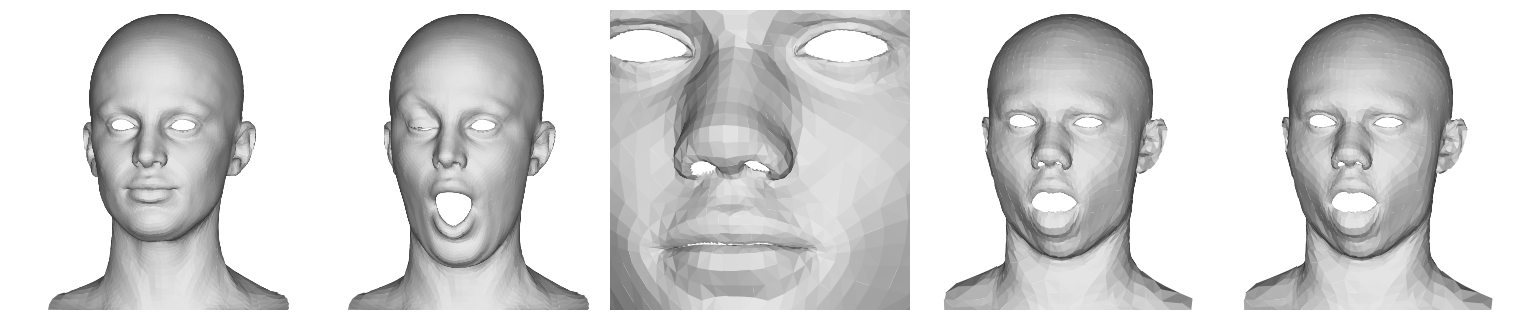

In [24]:
from matplotrender import *
# figure size
SIZE = 3
mesh_scale = .7
mesh_trans = np.array([0,0,0])
# mesh that you wanna render

v_list=[ V, displacements+V, 
        # np.matmul(newV, R.T)*M_DESCALE, 
        newV,
        np.matmul(new_displacements+newV, R.T)*M_DESCALE-trns, 
        (new_displacements+newV)*M_DESCALE-trns
       ]
v_list=[ v*mesh_scale+mesh_trans for v in v_list ]
f_list=[ F, F, newF, 
        # F, 
        newF, newF ]

# xyz Euler angle to rotate the mesh
rot_list=[ [0,-10,0] ]*len(v_list)

# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE)
# plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='normal')
plot_mesh_image(v_list, f_list, rot_list=rot_list, size=SIZE, mode='shade')